# Emerging Topics final code - Full

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns
import os

/home/eo9tv/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Data Ingestion

In [2]:
# full corpus
#df = pd.read_pickle("~/git/dspg21RnD/data/dspg21RnD/smaller-final-dataset.pkl")
df = pd.read_pickle("../smaller-final-dataset.pkl")

In [3]:
df.head()

,original index,PROJECT_ID,ABSTRACT,FY,ORG_COUNT,PI_COUNT,nchar,final_frqwds_removed,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS
0,17608,152242,The multiprotein complex y-secretase proteolyt...,2008,1,1,1402,"[multiprotein, y_secretase, proteolytically_cl...",Active Sites; Affect; Alzheimer's Disease; Am...,STRUCTURE OF SIGNAL PEPTIDE PEPTIDASE,HHS,NIH,NIA,5F32AG027647-03,12/1/2005,1/1/2008,"LIEBERMAN, RAQUEL L",NaN,07,030811269,BRIGHAM AND WOMEN'S HOSPITAL,BOSTON,MA,021156110,UNITED STATES,12/1/2007,1/1/2008,93.866,2008,3483.0,NaN
1,111864,190316,DESCRIPTION (provided by applicant): The Kis...,2008,1,1,2553,"[kissl, gene, encode, peptide, kisspeptin, bin...",Affect; Animal Model; Axon; Behavior; Behavio...,ROLE OF KISS1 NEURONS IN THE SEASONAL AND CIRC...,HHS,NIH,NICHD,5K99HD056157-02,9/1/2007,1/1/2009,"KAUFFMAN, ALEXANDER S",NaN,07,605799469,UNIVERSITY OF WASHINGTON,SEATTLE,WA,981959472,UNITED STATES,9/1/2008,1/1/2009,93.865,2008,39175.0,NaN
2,22052,154213,DESCRIPTION (provided by applicant): The objec...,2008,1,1,1414,"[biophysical, basis, thermodynamics_kinetic, m...",Agreement; Antibodies; base; Binding; Biochem...,CARBONIC ANHYDRASE AS A MODEL TO UNDERSTAND DI...,HHS,NIH,NIGMS,5F32GM076971-02,1/2/2007,1/1/2009,"MACK, ERIC T",NaN,05,082359691,HARVARD UNIVERSITY,CAMBRIDGE,MA,021385319,UNITED STATES,1/2/2008,1/1/2009,93.859,2008,49646.0,NaN
3,35004,159362,Obesity is the cause of many adverse pregnancy...,2008,1,1,1545,"[obesity, adverse_pregnancyoutcome, great, hea...",African; Analysis of Variance; Asians; Birth;...,OBESITY ON VAGAL TONE AND HBA1C DURING PREGNANCY,HHS,NIH,NINR,5F31NR009611-03,4/1/2006,1/1/2009,"HELMREICH, REBECCA J",NaN,09,800771594,UNIVERSITY OF TEXAS HLTH SCI CTR HOUSTON,HOUSTON,TX,770305400,UNITED STATES,4/1/2008,1/1/2009,93.361,2008,20406.0,NaN
4,371628,594482,Local potato advisory groups have expressed in...,2010,1,1,271,"[local, potato, advisory, express, interest, m...",cost; Health; interest; Manure; Parasitic nem...,PLANT-PARASITIC NEMATODE MANAGEMENT AS A COMPO...,USDA,NIFA,NaN,0219605,10/1/2009,1/1/2010,"CHARLTON, B.",NaN,NaN,053599908,OREGON STATE UNIVERSITY,CORVALLIS,OR,97331,UNITED STATES,NaN,NaN,10.203,2010,NaN,NaN


In [3]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []
docs = df["final_frqwds_removed"]

for abstract in docs:
    text.append(" ".join(abstract))

### Functions needed for all models

In [4]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [5]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF
- Optimal Model: full dataset, 75 topics, random_state = 14

In [6]:
# use for full dataset
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
tf_idf = tfidf_vectorizer.fit_transform(text)

In [7]:
# full dataset model ingestion

num_topics = 75

#doc_topic, topic_term = pickle.load(open('/home/eo9tv/git/dspg20RnD/data/final/opt_NMF_model/final_model_DT_TT.sav','rb'))
doc_topic, topic_term = pickle.load(open('../final_model_DT_TT.sav','rb'))

### Emerging Topics

In [8]:
# Extract Year from PROJECT_START_DATE

#On our graphs, we want to be able to show year. Therefore, this getYear function gets the year from different date formats from Project Start Year/End Year

#START

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [9]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]


#### compute count of projects with weight > 0 for each topic

In [10]:
topic_proj_count = topic_frame.copy()

In [11]:
topic_proj_count.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,...,Topic 51,Topic 52,Topic 53,Topic 54,Topic 55,Topic 56,Topic 57,Topic 58,Topic 59,Topic 60,Topic 61,Topic 62,Topic 63,Topic 64,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74,START_YEAR
0,0.000000,0.0,0.000171,0.0,0.0,0.001167,0.000000,0.000000,0.000000,0.001698,1.505964e-03,0.000000,0.000000,0.00000,0.008294,0.000200,0.012413,0.000000,0.000207,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.00398,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000027,0.0,0.0,0.000000,0.0,0.000771,0.000000,0.000000,0.000037,0.000000,0.000669,0.0,0.000767,0.000000,2005
1,0.000000,0.0,0.000000,0.0,0.0,0.000646,0.001446,0.000000,0.014818,0.000425,2.000608e-04,0.000012,0.000666,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000696,...,0.00000,0.000731,0.000000,0.000000,0.000000,0.0,0.000876,0.000032,0.0,0.000000,0.000000,0.0,0.0,0.005274,0.0,0.000000,0.001405,0.000000,0.000000,0.000000,0.007767,0.0,0.000000,0.000727,2007
2,0.000000,0.0,0.000095,0.0,0.0,0.000000,0.000391,0.002431,0.000000,0.003938,0.000000e+00,0.000085,0.000000,0.00000,0.002261,0.000000,0.000000,0.000000,0.000081,0.000187,0.000000,0.0,0.0,0.0,0.000708,...,0.00000,0.000000,0.000000,0.000000,0.000177,0.0,0.000010,0.000000,0.0,0.008123,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000039,0.000000,0.000689,0.000346,0.018710,0.0,0.000000,0.000000,2007
3,0.000000,0.0,0.000000,0.0,0.0,0.000172,0.000000,0.000000,0.000000,0.000000,7.809367e-07,0.000000,0.003662,0.00004,0.000000,0.001224,0.000000,0.000000,0.000000,0.000000,0.000476,0.0,0.0,0.0,0.000000,...,0.00000,0.004962,0.000804,0.000502,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000191,0.0,0.000000,0.029590,0.043594,0.000000,0.000389,0.000000,0.0,0.000000,0.000000,2006
4,0.000026,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.001600,0.000034,0.000000e+00,0.000171,0.000000,0.00000,0.000000,0.000000,0.000000,0.000018,0.000000,0.005571,0.000000,0.0,0.0,0.0,0.000000,...,0.00000,0.000000,0.002779,0.000000,0.000812,0.0,0.000917,0.000000,0.0,0.000000,0.002498,0.0,0.0,0.000000,0.0,0.000420,0.000000,0.000000,0.000330,0.000000,0.000169,0.0,0.000000,0.000423,2009


In [12]:
topic_count_bool = (topic_proj_count.iloc[:,0:75] > 0)
topic_count_bool["START_YEAR"] = topic_proj_count["START_YEAR"]

In [14]:
#topic_count_bool.sum(axis=0)

In [13]:
# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("START_YEAR").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "START_YEAR")  # pretty sure this is unnecessary
topic_counts["START_YEAR"] = topic_counts["START_YEAR"].astype(int)


In [16]:
#topic_counts

In [14]:
topic_counts_filt = topic_counts[topic_counts["START_YEAR"] > 2009] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["START_YEAR"] < 2020]

In [15]:
topic_counts_filt

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,...,Topic 50,Topic 51,Topic 52,Topic 53,Topic 54,Topic 55,Topic 56,Topic 57,Topic 58,Topic 59,Topic 60,Topic 61,Topic 62,Topic 63,Topic 64,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74
40,2010,32449,20518,22782,19683,22649,27944,25055,29414,23597,30525,31361,19637,18035,23467,23965,20760,17912,22240,21710,21481,33308,19689,22498,15513,...,18250,26778,22246,28795,21361,20021,21531,28084,16549,15380,19785,22666,20232,20551,21814,22736,25815,22897,20719,23138,20465,26639,19200,24790,19552
41,2011,29548,18392,21028,18229,20627,25762,23425,26585,21321,27208,28218,18101,16412,21185,21705,18739,16711,20195,19410,19794,28747,18193,20931,14422,...,15891,24561,19906,26476,19127,18209,19104,25389,14962,14426,17867,21101,18251,18268,19780,20379,23452,20863,18791,20451,18472,23969,17753,22393,17392
42,2012,25647,16840,18723,16302,18315,22714,20948,23695,18671,22853,25337,16124,14138,18019,19895,16815,15189,18295,16541,18416,26094,16177,19032,12835,...,13915,22182,17857,24250,16618,17295,17783,22293,13107,12889,15489,19416,16650,15842,17640,17726,21068,18623,16225,18616,15957,20749,15951,19559,15692
43,2013,20589,15153,15751,13785,14466,19396,18582,20099,15295,18331,20317,13352,11795,15254,15946,13896,12461,14646,13687,16514,17231,13269,16570,10305,...,12256,17826,15062,21007,13323,15581,14588,18272,10691,11181,13162,16217,13300,12840,14240,13752,18698,15858,12972,15541,13176,16385,12815,17808,13109
44,2014,22050,15294,16909,14538,15706,20244,19154,21315,16137,19377,22126,14307,12593,16012,17275,14696,13313,15819,14643,16909,17895,13750,16781,11073,...,12363,19336,15569,22195,14080,15684,15482,19288,11339,11808,13762,17424,14159,13658,15274,15032,19270,16420,13994,16354,14067,17421,13597,18220,13926
45,2015,20968,15130,15871,14012,15046,19985,18807,21281,15458,18566,21199,14118,11660,15995,16784,14257,12865,15148,14058,16552,17740,13059,16866,10736,...,11955,19066,15019,22588,13477,15814,15070,18900,10671,11696,13441,17232,13711,12966,14569,14229,18907,15507,13334,16256,13591,16286,13213,18107,13182
46,2016,21268,15736,15950,14203,15176,20181,18974,21265,15743,18766,21228,14012,11887,16031,16809,14315,13200,15044,14338,16073,17914,12959,17150,10700,...,11576,19139,15022,22737,13472,16058,15200,18383,10706,11722,13092,17436,13652,13044,14756,14482,19095,15620,13281,16237,13465,16220,13133,18606,13267
47,2017,20070,14668,14908,13699,14073,19254,18034,20024,15198,17440,20126,13023,10905,15251,15958,13312,12530,14172,13392,14176,16900,12216,15935,9928,...,10273,18135,14119,21379,12636,14993,14361,16971,9850,11361,11778,16425,12702,12188,13700,13504,17819,14528,12511,15087,12467,15250,12503,17148,12627
48,2018,20857,14834,15708,14153,14724,20134,18930,20498,15556,17862,21190,13700,11254,15802,16527,13612,13225,14925,13894,14501,17881,12543,16185,10571,...,10682,18909,14498,22262,12968,15720,14904,17417,10466,11696,11792,17452,13429,12508,14075,13913,18374,14878,12651,15445,12748,15433,13134,17743,13309
49,2019,16488,7311,13105,10951,10979,15679,14059,12654,11592,13943,17453,10190,8569,12255,13028,9918,10630,11797,10460,9427,12964,9519,10712,8241,...,6952,14677,10516,14655,10095,9748,10544,13302,8141,9155,7477,13163,10245,9642,10652,11002,13786,10483,9534,10483,9275,12137,10642,12950,10561


In [16]:
n_by_topic = topic_counts_filt.sum()[1:]

#### calculate mean topic weight by year and standard errors on means

In [17]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] > 2009] 
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] < 2020]

In [18]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [20]:
topic_frame.head()

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,...,Topic 50,Topic 51,Topic 52,Topic 53,Topic 54,Topic 55,Topic 56,Topic 57,Topic 58,Topic 59,Topic 60,Topic 61,Topic 62,Topic 63,Topic 64,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74
0,1965,0.001448,0.000000,0.000055,0.000007,0.000000,0.001045,0.000000,0.000363,0.001481,0.010815,0.000606,0.000000,1.361976e-03,0.000237,0.000351,0.000273,0.000672,0.000133,0.000000,0.000000,0.000389,0.000000,0.000001,0.005080,...,0.000235,0.000015,0.000149,0.000000,0.003766,0.000000,0.000000,0.001697,0.011014,0.000000,0.001098,0.0001,0.000193,0.006995,0.000526,0.000744,0.000000,0.000000,0.000019,0.000000,0.000124,0.002630,0.002138,0.000000,0.001342
1,1970,0.000029,0.000000,0.000010,0.000000,0.001288,0.000591,0.000799,0.000000,0.000102,0.001058,0.005853,0.001667,5.694811e-07,0.000106,0.016622,0.000000,0.000013,0.000000,0.000036,0.000111,0.000560,0.000000,0.000000,0.002451,...,0.000058,0.001769,0.000038,0.000204,0.004530,0.000000,0.000056,0.002844,0.000000,0.000000,0.000000,0.0000,0.002840,0.000289,0.000347,0.000000,0.000370,0.000000,0.000623,0.000696,0.000000,0.003864,0.000066,0.000000,0.014629
2,1972,0.000010,0.000653,0.000348,0.000093,0.000176,0.001246,0.001337,0.001748,0.000000,0.000000,0.000027,0.000000,0.000000e+00,0.000242,0.000000,0.000180,0.000059,0.000164,0.000001,0.000000,0.003920,0.000628,0.000000,0.000000,...,0.000147,0.000000,0.001300,0.000000,0.000037,0.000186,0.001944,0.000000,0.000034,0.000000,0.000000,0.0000,0.000070,0.000060,0.000566,0.000000,0.003319,0.000048,0.000734,0.000011,0.000440,0.000159,0.000429,0.007172,0.000093
3,1973,0.000065,0.000000,0.000000,0.000142,0.000000,0.000000,0.000000,0.000000,0.003875,0.001534,0.000027,0.000000,2.607549e-04,0.000025,0.002062,0.000000,0.000036,0.000086,0.000028,0.000000,0.000000,0.000702,0.000000,0.000000,...,0.000000,0.000000,0.000318,0.000000,0.001628,0.000000,0.000965,0.000136,0.000028,0.000000,0.000277,0.0000,0.000000,0.001229,0.000180,0.000267,0.000000,0.000028,0.001101,0.000000,0.000000,0.001757,0.005707,0.000067,0.000000
4,1974,0.001105,0.000123,0.000475,0.000638,0.000019,0.000911,0.000362,0.000890,0.001166,0.007915,0.000019,0.000015,6.646285e-04,0.000141,0.003477,0.000014,0.000012,0.000211,0.000557,0.000086,0.001198,0.000356,0.000007,0.000025,...,0.000265,0.000260,0.001020,0.000183,0.000213,0.000086,0.000529,0.000742,0.000230,0.000092,0.000786,0.0000,0.000348,0.003608,0.000151,0.000983,0.000282,0.000736,0.000280,0.000694,0.004027,0.009698,0.000040,0.000439,0.000119


In [19]:
# filter topic_frame for years 2010 - 2019

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2020] 

In [22]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,...,Topic 50,Topic 51,Topic 52,Topic 53,Topic 54,Topic 55,Topic 56,Topic 57,Topic 58,Topic 59,Topic 60,Topic 61,Topic 62,Topic 63,Topic 64,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74
40,2010,0.000509,0.001215,0.001682,0.000599,0.001239,0.000804,0.000890,0.001138,0.000498,0.001991,0.000863,0.000242,0.000310,0.000513,0.000734,0.000295,0.000216,0.000601,0.000397,0.000289,0.001162,0.000774,0.000266,0.000513,...,0.000549,0.000619,0.000677,0.001214,0.000774,0.000779,0.000890,0.001127,0.000545,0.000491,0.000899,0.001060,0.000835,0.000725,0.000455,0.000940,0.001377,0.000929,0.000835,0.000871,0.000887,0.001887,0.000671,0.001796,0.001525
41,2011,0.000506,0.001197,0.001725,0.000595,0.001255,0.000851,0.000993,0.001139,0.000508,0.001904,0.000867,0.000263,0.000293,0.000501,0.000766,0.000272,0.000256,0.000643,0.000398,0.000291,0.001145,0.000768,0.000277,0.000554,...,0.000496,0.000632,0.000667,0.001244,0.000781,0.000784,0.000877,0.001140,0.000466,0.000476,0.000874,0.001065,0.000836,0.000749,0.000462,0.000912,0.001377,0.000963,0.000871,0.000885,0.000876,0.001771,0.000684,0.001671,0.001478
42,2012,0.000496,0.001271,0.001753,0.000611,0.001236,0.000872,0.001060,0.001205,0.000510,0.001561,0.000928,0.000264,0.000274,0.000460,0.000782,0.000300,0.000265,0.000634,0.000371,0.000329,0.001202,0.000900,0.000286,0.000551,...,0.000546,0.000648,0.000712,0.001339,0.000707,0.000857,0.000970,0.001071,0.000472,0.000453,0.000948,0.001188,0.000887,0.000664,0.000567,0.000821,0.001362,0.000944,0.000845,0.000962,0.000830,0.001640,0.000730,0.001602,0.001579
43,2013,0.000454,0.001424,0.001812,0.000533,0.001080,0.000869,0.001315,0.001280,0.000481,0.001408,0.000861,0.000236,0.000261,0.000440,0.000693,0.000255,0.000255,0.000603,0.000355,0.000383,0.000951,0.000688,0.000305,0.000513,...,0.000663,0.000610,0.000649,0.001478,0.000653,0.000948,0.000825,0.001056,0.000404,0.000550,0.000980,0.001098,0.000783,0.000623,0.000421,0.000698,0.001579,0.000902,0.000735,0.000928,0.000792,0.001450,0.000586,0.001882,0.001461
44,2014,0.000471,0.001261,0.001932,0.000541,0.001111,0.000829,0.001287,0.001287,0.000497,0.001437,0.000911,0.000237,0.000277,0.000467,0.000759,0.000253,0.000284,0.000620,0.000373,0.000353,0.000949,0.000696,0.000288,0.000513,...,0.000602,0.000648,0.000661,0.001480,0.000648,0.000951,0.000873,0.001050,0.000409,0.000514,0.001037,0.001144,0.000820,0.000643,0.000435,0.000729,0.001565,0.000874,0.000728,0.000939,0.000762,0.001459,0.000638,0.001848,0.001486
45,2015,0.000440,0.001360,0.001747,0.000538,0.001101,0.000812,0.001326,0.001371,0.000475,0.001356,0.000864,0.000238,0.000255,0.000467,0.000753,0.000259,0.000287,0.000597,0.000362,0.000368,0.000925,0.000630,0.000314,0.000516,...,0.000638,0.000712,0.000632,0.001578,0.000617,0.001030,0.000861,0.001038,0.000371,0.000535,0.001078,0.001060,0.000814,0.000659,0.000418,0.000666,0.001648,0.000787,0.000751,0.001033,0.000766,0.001284,0.000603,0.001886,0.001373
46,2016,0.000441,0.001389,0.001741,0.000580,0.001112,0.000828,0.001326,0.001387,0.000484,0.001380,0.000877,0.000240,0.000255,0.000472,0.000748,0.000251,0.000353,0.000562,0.000366,0.000294,0.000948,0.000662,0.000312,0.000519,...,0.000513,0.000696,0.000620,0.001619,0.000647,0.001021,0.000899,0.001009,0.000388,0.000493,0.000960,0.001120,0.000837,0.000678,0.000484,0.000784,0.001760,0.000832,0.000792,0.001007,0.000758,0.001241,0.000673,0.001939,0.001441
47,2017,0.000447,0.001377,0.001763,0.000558,0.001101,0.000843,0.001425,0.001413,0.000526,0.001310,0.000899,0.000224,0.000241,0.000491,0.000763,0.000250,0.000454,0.000593,0.000370,0.000220,0.000909,0.000673,0.000302,0.000510,...,0.000390,0.000708,0.000650,0.001593,0.000627,0.000985,0.000928,0.000999,0.000415,0.000539,0.000939,0.001146,0.000864,0.000692,0.000524,0.000765,0.001818,0

In [23]:
topic_wts_se_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,...,Topic 50,Topic 51,Topic 52,Topic 53,Topic 54,Topic 55,Topic 56,Topic 57,Topic 58,Topic 59,Topic 60,Topic 61,Topic 62,Topic 63,Topic 64,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74
40,2010,0.000004,0.000015,0.000022,0.000013,0.000019,0.000009,0.000013,0.000011,0.000007,0.000020,0.000009,0.000005,0.000005,0.000007,0.000010,0.000005,0.000007,0.000010,0.000007,0.000004,0.000011,0.000023,0.000004,0.000012,...,0.000014,0.000007,0.000012,0.000011,0.000011,0.000013,0.000013,0.000014,0.000016,0.000017,0.000019,0.000016,0.000016,0.000014,0.000017,0.000019,0.000015,0.000014,0.000016,0.000019,0.000022,0.000022,0.000023,0.000021,0.000022
41,2011,0.000004,0.000016,0.000023,0.000013,0.000020,0.000010,0.000015,0.000012,0.000008,0.000020,0.000009,0.000006,0.000005,0.000008,0.000011,0.000005,0.000008,0.000011,0.000007,0.000004,0.000012,0.000023,0.000005,0.000014,...,0.000014,0.000008,0.000013,0.000012,0.000011,0.000015,0.000013,0.000015,0.000014,0.000017,0.000020,0.000016,0.000018,0.000016,0.000019,0.000019,0.000016,0.000016,0.000018,0.000022,0.000022,0.000022,0.000025,0.000021,0.000022
42,2012,0.000005,0.000017,0.000025,0.000014,0.000021,0.000011,0.000017,0.000013,0.000008,0.000019,0.000010,0.000006,0.000005,0.000008,0.000012,0.000006,0.000009,0.000011,0.000007,0.000005,0.000013,0.000027,0.000005,0.000014,...,0.000015,0.000008,0.000015,0.000013,0.000011,0.000015,0.000015,0.000015,0.000015,0.000018,0.000023,0.000019,0.000020,0.000015,0.000023,0.000019,0.000017,0.000016,0.000019,0.000022,0.000023,0.000022,0.000027,0.000021,0.000025
43,2013,0.000005,0.000020,0.000028,0.000014,0.000021,0.000012,0.000021,0.000015,0.000009,0.000020,0.000011,0.000006,0.000005,0.000008,0.000012,0.000006,0.000009,0.000012,0.000007,0.000006,0.000013,0.000025,0.000005,0.000015,...,0.000018,0.000009,0.000014,0.000016,0.000012,0.000018,0.000014,0.000016,0.000015,0.000023,0.000024,0.000020,0.000020,0.000016,0.000020,0.000018,0.000021,0.000017,0.000018,0.000023,0.000025,0.000023,0.000025,0.000025,0.000026
44,2014,0.000005,0.000018,0.000028,0.000014,0.000021,0.000011,0.000021,0.000014,0.000009,0.000019,0.000010,0.000006,0.000006,0.000008,0.000012,0.000005,0.000010,0.000012,0.000008,0.000005,0.000013,0.000024,0.000005,0.000014,...,0.000017,0.000009,0.000015,0.000015,0.000011,0.000019,0.000014,0.000016,0.000014,0.000021,0.000026,0.000019,0.000020,0.000016,0.000020,0.000018,0.000021,0.000017,0.000017,0.000025,0.000023,0.000022,0.000026,0.000025,0.000025
45,2015,0.000005,0.000020,0.000028,0.000014,0.000021,0.000011,0.000021,0.000015,0.000009,0.000019,0.000010,0.000006,0.000005,0.000008,0.000013,0.000006,0.000010,0.000011,0.000007,0.000005,0.000013,0.000023,0.000006,0.000015,...,0.000018,0.000011,0.000014,0.000016,0.000011,0.000020,0.000014,0.000016,0.000014,0.000022,0.000026,0.000018,0.000020,0.000017,0.000020,0.000018,0.000022,0.000015,0.000019,0.000027,0.000024,0.000021,0.000024,0.000025,0.000025
46,2016,0.000005,0.000020,0.000027,0.000015,0.000021,0.000011,0.000021,0.000015,0.000009,0.000019,0.000010,0.000006,0.000005,0.000008,0.000012,0.000005,0.000012,0.000011,0.000007,0.000005,0.000013,0.000024,0.000006,0.000014,...,0.000016,0.000012,0.000014,0.000016,0.000011,0.000020,0.000015,0.000016,0.000014,0.000020,0.000025,0.000018,0.000021,0.000018,0.000022,0.000020,0.000023,0.000016,0.000019,0.000027,0.000023,0.000020,0.000026,0.000024,0.000026
47,2017,0.000005,0.000020,0.000027,0.000015,0.000021,0.000011,0.000023,0.000016,0.000009,0.000019,0.000011,0.000006,0.000005,0.000009,0.000013,0.000006,0.000014,0.000012,0.000008,0.000004,0.000012,0.000025,0.000006,0.000015,...,0.000014,0.000012,0.000015,0.000016,0.000011,0.000020,0.000015,0.000017,0.000015,0.000022,0.000026,0.000019,0.000022,0.000018,0.000025,0.000020,0.000024,0

In [20]:
# perform regressions, track slopes

topic_slopes = []

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    
    topic_slopes.append(linear_fit.coef_[0][0])

In [21]:
hot_cold = []

for slope in topic_slopes:
    if slope > 0:
        hot_cold.append("hot")
    else:
        hot_cold.append("cold")

In [22]:
topic_words = str_topics(topic_term, tfidf_vectorizer, top_n = 5)

In [23]:
# package up data for data table in RShiny dashboard

reg_topics = pd.DataFrame()
reg_topics["Slope"] = topic_slopes
#reg_topics["Hot or Cold"] = hot_cold
reg_topics["Topic Words"] = topic_words 

In [24]:
reg_topics = reg_topics.sort_values('Topic Words')

In [25]:
topic_label_num = range(1, 76)
topic_label = ["FR" + str(x) for x in topic_label_num]
reg_topics["Topic Label"] = topic_label

In [78]:
reg_topics.to_csv("full_topics_df.csv", index=False)
#reg_topics.to_csv("./pan_topics.csv", index=False)
#reg_topics.to_csv("./cor_topics.csv", index=False)

## Create plot - top 10 hot and cold topics

In [26]:
# legend
leg = str_topics(topic_term, tfidf_vectorizer, top_n = 5)

In [27]:
#Make Graphs
#leg = []
topic_results = {}
#fig = plt.figure()
#fig.suptitle('Hot and Cold Topics', fontsize=16)
#ax = fig.add_subplot(111)

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    topic_results[i] = [linear_fit.coef_[0][0], reg_topics.loc[i-1, "Topic Label"]]
    #ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,i])
    #leg.append("Topic %d"%(n+1))

#plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
#plt.xlabel('Year', fontsize=12)
#plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)
#plt.legend(leg,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
#plt.show()

In [28]:
class HandlerDashedLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines

In [29]:
def sort_dict(x):
    return sorted(x.items(), key=lambda l: l[1], reverse=True)

In [32]:
sort_slopes = sort_dict(topic_results)
top_slopes = [x[0] for x in sort_slopes[:10]]
bottom_slopes = [x[0] for x in sort_slopes[-10:]]
topnbot_slopes = top_slopes + bottom_slopes

### plot hottest and coldest on same plot

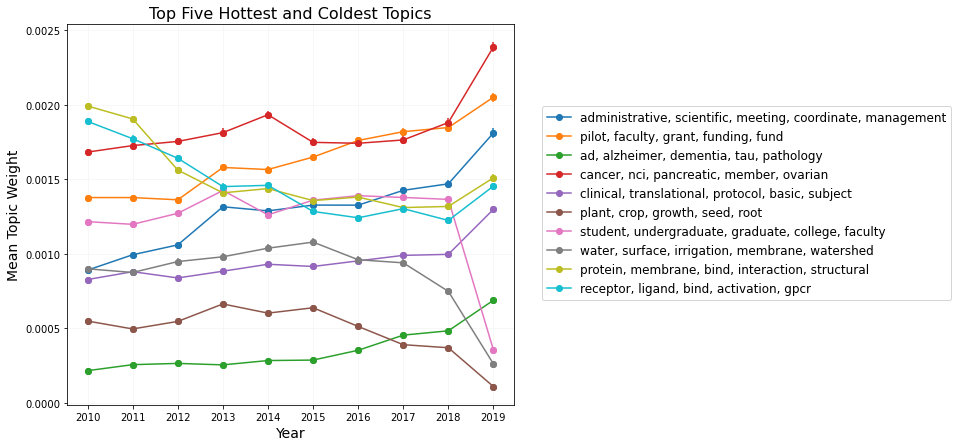

In [39]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]


line_return = []
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in topnbot_slopes:
    zorder = 20
    color = color_list[i] 
    #if i < 5:
    #    zorder = 10 #10
    #    color = "#D3D3D3";
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
#plt.ylim(bottom = -0.001, top = 0.05)
plt.title('Top Five Hottest and Coldest Topics', fontsize=16)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
#plt.legend(line_return, [leg[x-1] for x in topnbot_slopes], handler_map={type(line_return[0]): HandlerDashedLines()})
           #handlelength=2, bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')  #handleheight=2,

plt.legend([leg[x-1] for x in topnbot_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/updated_full_hot_cold_topics.png", dpi = 800, bbox_inches = "tight")
plt.show()


### Plot hottest and coldest topics on separate plots

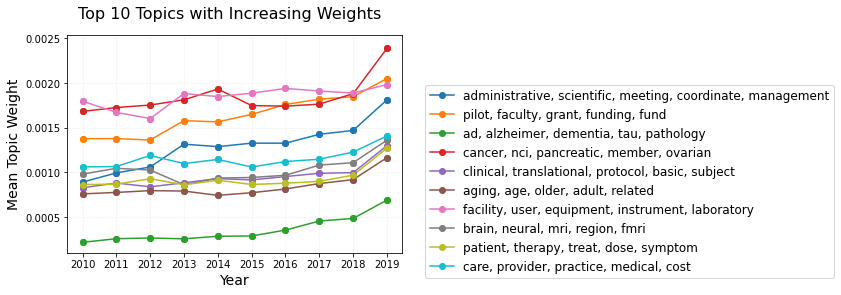

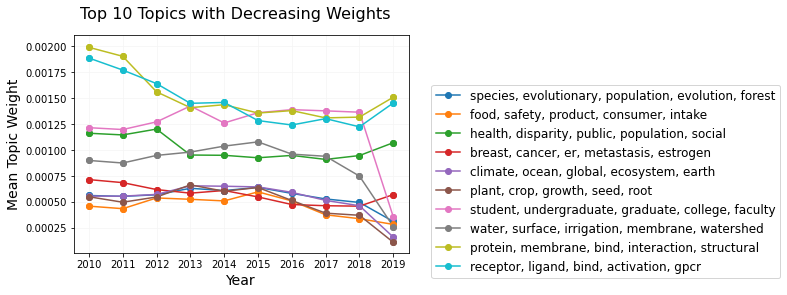

In [40]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]
#color_list = ["#D3D3D3","#2c4f6b","#C0C0C0","#A9A9A9","#808080","#D3D3D3","#2c4f6b","#D3D3D3","#D3D3D3", "#D3D3D3"] #"#fdfdfd"]


line_return = []
fig = plt.figure()
fig.suptitle('Top 10 Topics with Increasing Weights', fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in top_slopes:
    zorder = 10
    color = color_list[i] # "#D3D3D3"   
    if i == 0:
        zorder = 10 #20
        color = color_list[i];
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
#plt.ylim(bottom = -0.002, top = 0.065)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
#plt.legend(line_return, [leg[x-1] for x in top_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in top_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
plt.savefig("full_increasing_topics_final.png", dpi = 800, bbox_inches = "tight")
plt.show()


#Make Graphs
#leg = []

#bottom_slopes.reverse()  # so the plot legend has the coldest listed first

line_return = []
fig = plt.figure()
fig.suptitle('Top 10 Topics with Decreasing Weights', fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
i = 0
for n in bottom_slopes:
    zorder = 10
    color = color_list[i]  #"#D3D3D3"  
    if i == 4:
        zorder = 10 #20
        color = color_list[i]
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i+5])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color=color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color=color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i+5],color_list[i+5]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
#plt.ylim(bottom = -0.002, top = 0.065)
#ax.yaxis.set_label_coords(-0.14,0.5)


# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
#plt.legend(line_return, [leg[x-1] for x in bottom_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in bottom_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
plt.savefig("full_decreasing_topics_final.png", dpi = 800, bbox_inches = "tight")
plt.show()


### create plot for specific topics

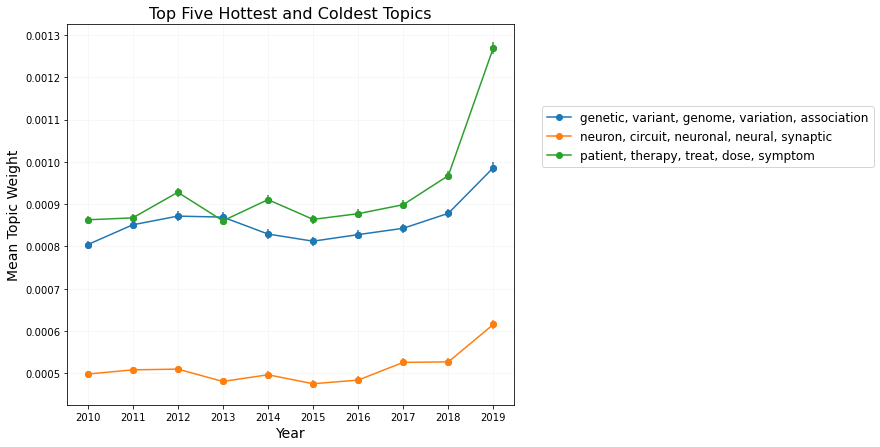

In [41]:
# Create plots for data stories in ET paper - topic numbers: 5, 8, 10 + 1 due to year being column 1

topic_idx = [6, 9, 11]

# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]


line_return = []
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in topic_idx:
    zorder = 20
    color = color_list[i] 
    #if i < 5:
    #    zorder = 10 #10
    #    color = "#D3D3D3";
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
#plt.ylim(bottom = -0.001, top = 0.05)
plt.title('Top Five Hottest and Coldest Topics', fontsize=16)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
#plt.legend(line_return, [leg[x-1] for x in topic_idx], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in topic_idx], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/case-study.png", dpi = 800, bbox_inches = "tight")
plt.show()


## Plot for each topic in a grid

In [56]:
# get order of plots
sorted_slopes = [x[0] for x in sort_slopes]
sorted_labels = [x[1][1] for x in sort_slopes]

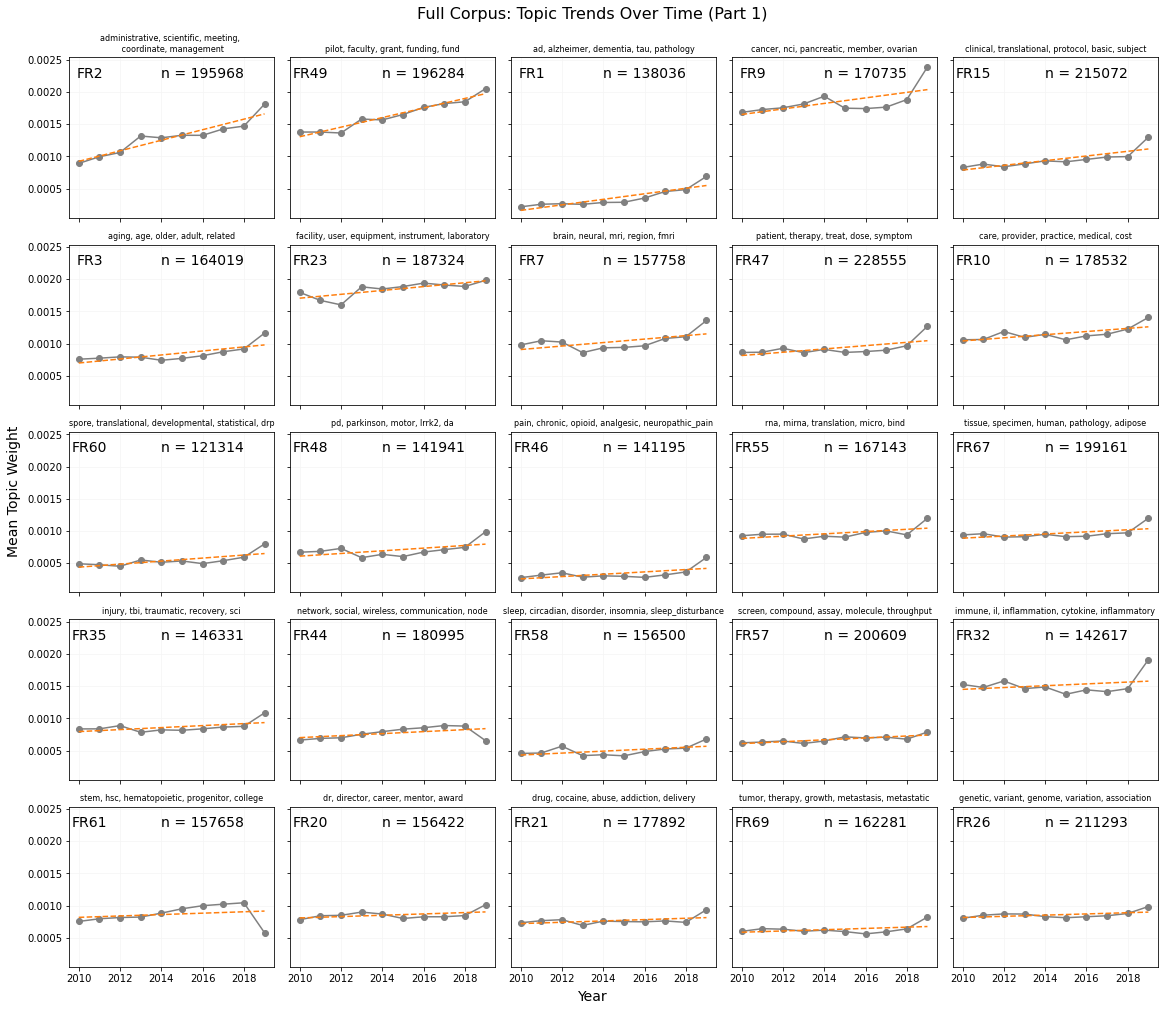

In [68]:
# set up grid
fig, ax = plt.subplots(5, 5, sharex = True, sharey = True, figsize=(16,14))
#plt.ylim(bottom = -0.002, top = 0.065)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes[0:25]):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")

    # put legend on two lines for topics 2, 28
    if count == 0:
        ax[i,j].set_title('administrative, scientific, meeting, \n coordinate, management', \
                          fontsize = 8)
    else:
        ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    #ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[i,j].transAxes, fontsize = 14)
    #ax[i,j].text(0.08, 0.90, str(col_idx), horizontalalignment='center', verticalalignment='center', \
    #         transform=ax[i,j].transAxes, fontsize = 14)
    ax[i,j].text(0.1, 0.90, sorted_labels[count], horizontalalignment='center', verticalalignment='center', \
         transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.65, 0.90, "n = " + str(n_by_topic[col_idx-1]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
fig.suptitle('Full Corpus: Topic Trends Over Time (Part 1)', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

plt.savefig("full_topic_trends1.png", dpi = 800, bbox_inches = "tight")
plt.show()

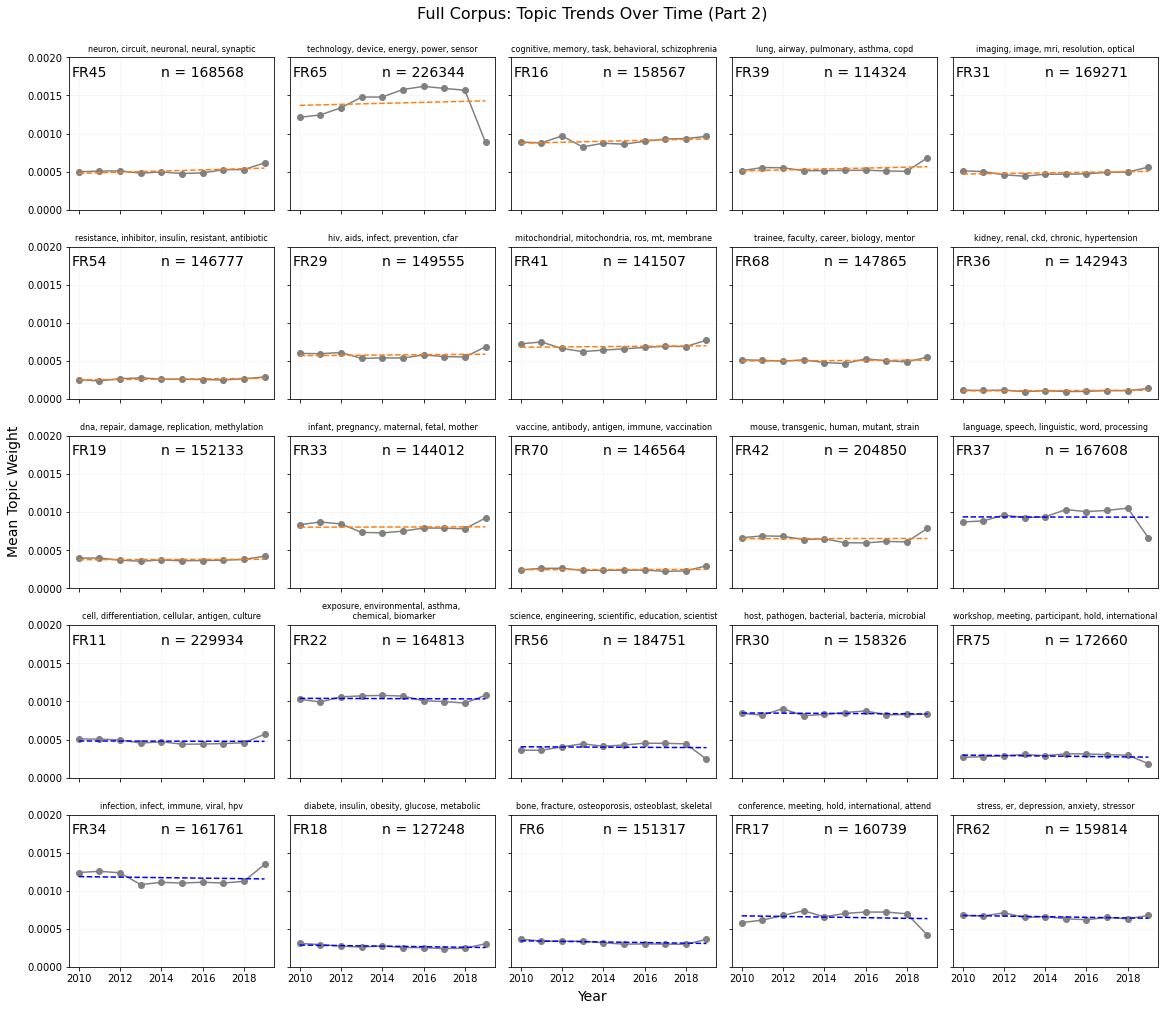

In [70]:
# set up grid
fig, ax = plt.subplots(5, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(top = 0.002)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes[25:50]):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # put legend on two lines for topics 2, 28
    if count == 16:
        ax[i,j].set_title('exposure, environmental, asthma, \n chemical, biomarker', \
                          fontsize = 8) 
    else:
        ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    #ax[i,j].text(0.08, 0.90, str(col_idx), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[i,j].transAxes, fontsize = 14)
    ax[i,j].text(0.1, 0.90, sorted_labels[25+count], horizontalalignment='center', verticalalignment='center', \
         transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.65, 0.90, "n = " + str(n_by_topic[col_idx-1]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
fig.suptitle('Full Corpus: Topic Trends Over Time (Part 2)', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

plt.savefig("full_topic_trends2.png", dpi = 800, bbox_inches = "tight")
plt.show()

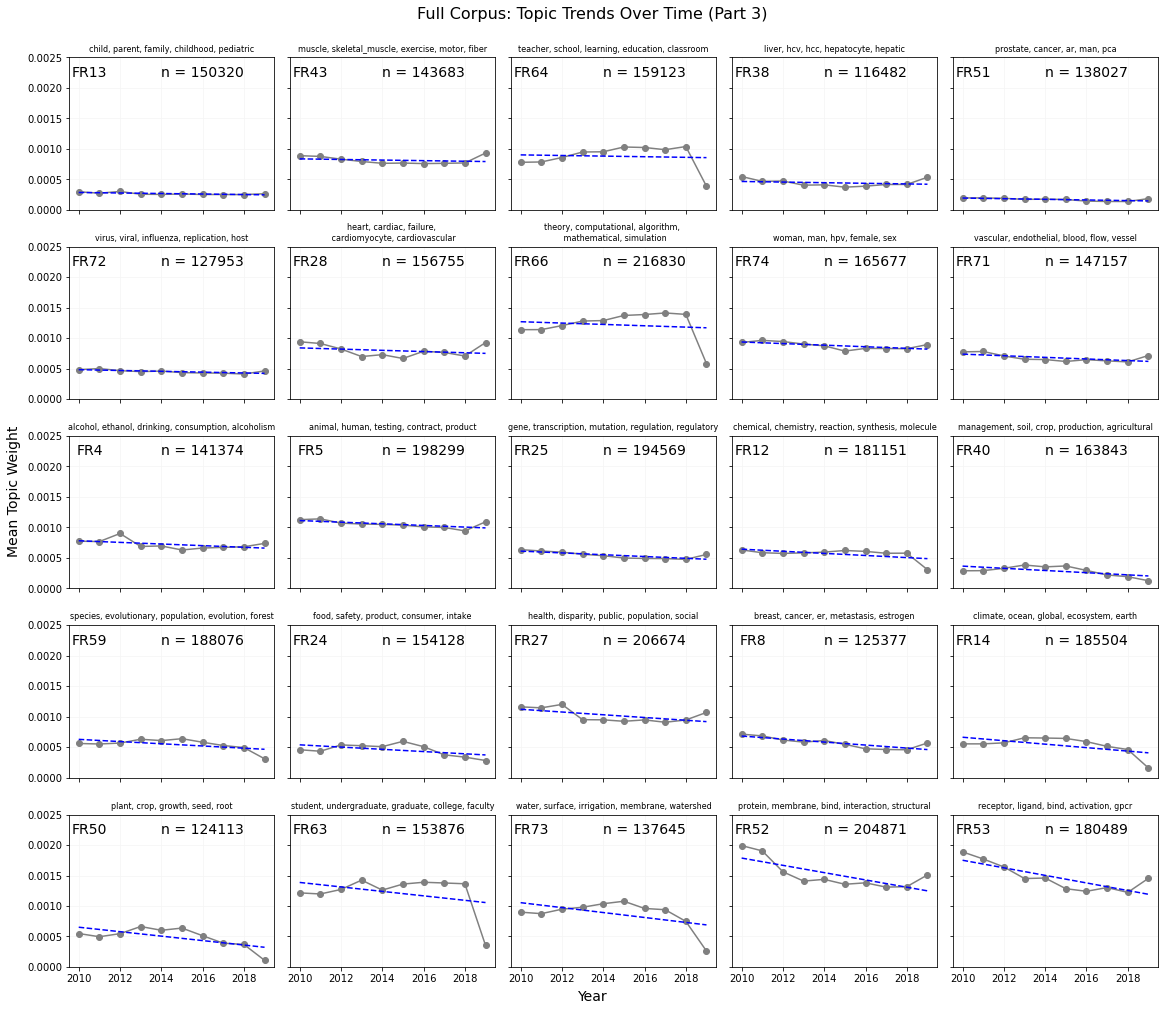

In [72]:
# set up grid
fig, ax = plt.subplots(5, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(top = 0.0025)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes[50:75]):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")

    # put legend on two lines for topics 2, 28
    if count == 6:
        ax[i,j].set_title('heart, cardiac, failure, \n cardiomyocyte, cardiovascular', \
                          fontsize = 8)
    elif count == 7:
        ax[i,j].set_title('theory, computational, algorithm, \n mathematical, simulation', \
                          fontsize = 8)        
    else:
        ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    #ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[i,j].transAxes, fontsize = 14)
    #ax[i,j].text(0.08, 0.90, str(col_idx), horizontalalignment='center', verticalalignment='center', \
    #         transform=ax[i,j].transAxes, fontsize = 14)
    ax[i,j].text(0.1, 0.90, sorted_labels[50+count], horizontalalignment='center', verticalalignment='center', \
         transform=ax[i,j].transAxes, fontsize = 14)    
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.65, 0.90, "n = " + str(n_by_topic[col_idx-1]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
fig.suptitle('Full Corpus: Topic Trends Over Time (Part 3)', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

plt.savefig("full_topic_trends3.png", dpi = 800, bbox_inches = "tight")
plt.show()